In [34]:
import pandas as pd
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV
from bayes_opt import BayesianOptimization
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np


In [35]:
df = pd.read_csv("used_cars_data.csv")

# Data Augementation

In [36]:
def augment_data(df, features, fraction=0.05):
    """
    Augment data by adding jittering.
    
    Parameters:
    - df: DataFrame to augment.
    - features: List of feature columns to which jittering should be applied.
    - fraction: Fraction of noise to add to the data.
    
    Returns:
    - Augmented DataFrame.
    """
    augmented_df = df.copy()
    for feature in features:
        noise = np.random.normal(0, fraction * df[feature].std(), size=df[feature].shape)
        augmented_df[feature] = df[feature] + noise
    return augmented_df


In [37]:
# Augment the data
augmented_df = augment_data(df, features=['mileage (kms)', 'year'])


## Data Preprocessing

In [38]:
enc = OneHotEncoder(handle_unknown='ignore')

In [39]:
X = df[['brand', 'fuel', 'gearbox']]

In [40]:
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [41]:
X_features = pd.DataFrame(enc.transform(df[['brand', 'fuel', 'gearbox']]).toarray())


## Feature Engineering

Calculate the age of the car and other potential features

In [42]:
year = datetime.datetime.now().year

In [43]:
df['age'] = year - df['year']
df['mileage_per_year'] = df['mileage (kms)'] / df['age']
X_num = df[['age', 'mileage (kms)', 'mileage_per_year']]
y = df['price (eur)']

In [44]:
X = pd.concat([X_num, X_features], axis=1)

In [45]:
X.columns = X.columns.astype(str)

Feature Selection using Recursive Feature Elimination with cross-validation (RFECV)

RFECV helps in selecting the most important features for the model.

In [46]:
selector = RFECV(estimator=GradientBoostingRegressor(), step=1, cv=StratifiedKFold(5))
X_selected = selector.fit_transform(X, y)


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Model Training with Cross-validation

StratifiedKFold ensures that each fold has the same proportion of observations with a given label.

In [47]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hyperparameter tuning with Bayesian Optimization for Gradient Boosting

Bayesian Optimization helps in finding the best hyperparameters for the model.

In [48]:
def optimize_gb(n_estimators, learning_rate, max_depth, subsample, min_samples_split, min_samples_leaf):
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        n_iter_no_change=10,
        validation_fraction=0.1,
        tol=0.01
    )
    return cross_val_score(model, X_selected, y, cv=kf, scoring='neg_mean_squared_error').mean()


In [49]:
optimizer = BayesianOptimization(
    f=optimize_gb,
    pbounds={
        "n_estimators": (50, 300),
        "learning_rate": (0.01, 0.3),
        "max_depth": (3, 10),
        "subsample": (0.5, 1.0),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 10)
    },
    random_state=42,
)

In [50]:
optimizer.maximize(n_iter=15)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 1         | -2.737e+0 | 0.1186    | 9.655     | 7.588     | 6.789     | 89.0      | 0.578     |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 2         | -2.745e+0 | 0.02684   | 9.063     | 6.41      | 7.665     | 55.15     | 0.985     |
| 3         | -2.636e+0 | 0.2514    | 4.486     | 2.636     | 3.467     | 126.1     | 0.7624    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 4         | -2.618e+0 | 0.1353    | 5.039     | 6.507     | 3.116     | 123.0     | 0.6832    |
| 5         | -2.654e+0 | 0.1423    | 8.496     | 2.797     | 6.114     | 198.1     | 0.5232    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 6         | -2.915e+0 | 0.01      | 10.0      | 10.0      | 2.0       | 145.5     | 0.5       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 7         | -2.502e+0 | 0.3       | 3.0       | 1.0       | 10.0      | 114.1     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 8         | -2.716e+0 | 0.01      | 10.0      | 1.0       | 2.0       | 109.6     | 0.5       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 9         | -2.597e+0 | 0.2308    | 3.34      | 8.918     | 9.187     | 113.2     | 0.9054    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 10        | -2.575e+0 | 0.2585    | 8.09      | 2.311     | 9.886     | 119.7     | 0.8494    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 11        | -2.387e+0 | 0.08382   | 7.081     | 2.097     | 9.22      | 227.6     | 0.9633    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 12        | -2.616e+0 | 0.08885   | 7.548     | 2.993     | 9.001     | 228.8     | 0.6614    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 13        | -2.253e+0 | 0.1735    | 5.826     | 2.012     | 9.054     | 227.4     | 0.5535    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 14        | -2.487e+0 | 0.1473    | 5.747     | 1.291     | 9.276     | 226.5     | 0.9044    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 15        | -2.446e+0 | 0.02269   | 6.127     | 1.537     | 8.817     | 229.1     | 0.5705    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 16        | -2.55e+07 | 0.03741   | 5.702     | 2.388     | 8.183     | 227.6     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 17        | -2.513e+0 | 0.05068   | 5.485     | 2.441     | 9.105     | 228.3     | 0.8459    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 18        | -2.267e+0 | 0.1556    | 6.745     | 1.074     | 8.205     | 228.7     | 0.8016    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 19        | -2.339e+0 | 0.04517   | 4.444     | 1.986     | 9.838     | 227.3     | 0.759     |
| 20        | -2.748e+0 | 0.2531    | 4.127     | 2.966     | 9.216     | 227.5     | 0.5723    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# Hyperparameter Tuning

Train the best model using the best hyperparameters


In [51]:
best_params = optimizer.max['params']
regr_best = GradientBoostingRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=0.01
)

In [52]:
regr_best.fit(X_selected, y)


GradientBoostingRegressor(learning_rate=0.17346340148429604, max_depth=5,
                          min_samples_leaf=2, min_samples_split=9,
                          n_estimators=227, n_iter_no_change=10,
                          subsample=0.5535368977836441, tol=0.01)

## Model Evaluation

Calculate the RMSE and MAE to evaluate the model's performance.

In [53]:
y_pred = regr_best.predict(X_selected)
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)


Helps in understanding which features are most important for the model.

In [54]:
feature_importance = regr_best.feature_importances_
sorted_idx = feature_importance.argsort()

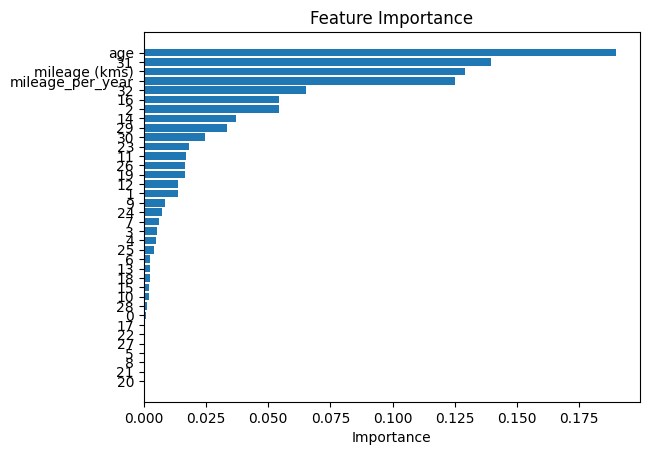

In [55]:
plt.barh(range(X_selected.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_selected.shape[1]), X.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [60]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 3265.653287444725
Mean Absolute Error (MAE): 2315.9624194985518


## Saving the model

In [57]:
dump(regr_best, 'model_best.joblib')
dump(enc, 'encoder.joblib')

['encoder.joblib']